### **HYPOTHESIS 1**

- Hypothesis: Does incident rate drop if we put higher skilled drivers in grid positions that are labeled higher risk and if we put lower skilled drivers to grid positions that are labeled lower risk? We aim to analyze the correlation between grid position and incident probability, categorizing positions into five risk levels: 1, 2, 3,  where 1 represents the lowest probability of an incident and 3 represents the highest probability. Each driver is assigned a skill level, and drivers with higher skill levels are placed in higher-risk positions, medium-skilled drivers in medium-risk positions, and low-skilled drivers in lower-risk positions. The goal is to investigate whether this specific arrangement of skill levels and grid positions impacts incident probability, particularly in terms of how the positioning of less-skilled drivers in lower-risk positions might influence the likelihood of incidents.

### **IMPORTS**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro, kstest
from scipy.stats import f_oneway, kruskal, bartlett, levene
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning)

### **IMPORTING DATASET**

In [3]:
circuits = pd.read_csv('./f1_dataset/circuits.csv')
constructor_results = pd.read_csv('./f1_dataset/constructor_results.csv')
constructor_standings = pd.read_csv('./f1_dataset/constructor_standings.csv')
constructors = pd.read_csv('./f1_dataset/constructors.csv')
driver_standings = pd.read_csv('./f1_dataset/driver_standings.csv')
drivers = pd.read_csv('./f1_dataset/drivers.csv')
lap_times = pd.read_csv('./f1_dataset/lap_times.csv')
pit_stops = pd.read_csv('./f1_dataset/pit_stops.csv')
qualifying = pd.read_csv('./f1_dataset/qualifying.csv')
races = pd.read_csv('./f1_dataset/races.csv')
results = pd.read_csv('./f1_dataset/results.csv')
seasons = pd.read_csv('./f1_dataset/seasons.csv')
sprint_results = pd.read_csv('./f1_dataset/sprint_results.csv')
status = pd.read_csv('./f1_dataset/status.csv')

In [5]:
print("circuits: ", ', '.join(circuits.columns.to_list()))
print("constructor_results: ", ', '.join(constructor_results.columns.to_list()))
print("constructor_standings: ", ', '.join(constructor_standings.columns.to_list()))
print("constructors: ", ', '.join(constructors.columns.to_list()))
print("driver_standings: ", ', '.join(driver_standings.columns.to_list()))
print("drivers: ", ', '.join(drivers.columns.to_list()))
print("lap_times: ", ', '.join(lap_times.columns.to_list()))
print("pit_stops: ", ', '.join(pit_stops.columns.to_list()))
print("qualifying: ", ', '.join(qualifying.columns.to_list()))
print("races: ", ', '.join(races.columns.to_list()))
print("results: ", ', '.join(results.columns.to_list()))
print("seasons: ", ', '.join(seasons.columns.to_list()))
print("sprint_results: ", ', '.join(sprint_results.columns.to_list()))
print("status: ", ', '.join(status.columns.to_list()))

circuits:  circuitId, circuitRef, name, location, country, lat, lng, alt, url
constructor_results:  constructorResultsId, raceId, constructorId, points, status
constructor_standings:  constructorStandingsId, raceId, constructorId, points, position, positionText, wins
constructors:  constructorId, constructorRef, name, nationality, url
driver_standings:  driverStandingsId, raceId, driverId, points, position, positionText, wins
drivers:  driverId, driverRef, number, code, forename, surname, dob, nationality, url
lap_times:  raceId, driverId, lap, position, time, milliseconds
pit_stops:  raceId, driverId, stop, lap, time, duration, milliseconds
qualifying:  qualifyId, raceId, driverId, constructorId, number, position, q1, q2, q3
races:  raceId, year, round, circuitId, name, date, time, url, fp1_date, fp1_time, fp2_date, fp2_time, fp3_date, fp3_time, quali_date, quali_time, sprint_date, sprint_time
results:  resultId, raceId, driverId, constructorId, number, grid, position, positionText, p

### Description of variables

In [7]:
# Define a dictionary for each dataset and its important variables with descriptions

dataset_info = {
    "Results": {
        "raceId": "Identifies the specific race event. This is critical for associating the results with a particular race.",
        "driverId": "Identifies the driver. This is essential for matching each driver to their race results.",
        "grid": "The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.",
        "position": "The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.",
        "statusId": "Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.",
        "points": "The number of points awarded based on the driver's performance."
    },
    "Status": {
        "statusId": "Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the race or had an incident."
    }
}

# Function to print dataset variable explanations
def print_dataset_info(dataset_info):
    for dataset, variables in dataset_info.items():
        print(f"Dataset: {dataset}")
        for var, description in variables.items():
            print(f"  - {var}: {description}")
        print("\n")

# Call the function to print the dataset information
print_dataset_info(dataset_info)


Dataset: Results
  - raceId: Identifies the specific race event. This is critical for associating the results with a particular race.
  - driverId: Identifies the driver. This is essential for matching each driver to their race results.
  - grid: The position from where a driver started the race (determined during qualifying). This is important for evaluating the risk level based on starting position.
  - position: The final position of the driver in the race. This will help in analyzing performance and outcome based on the starting position.
  - statusId: Indicates the status of the race for the driver (e.g., finished, retired, etc.). It helps to understand whether a driver finished the race and can be used to evaluate race incidents.
  - points: The number of points awarded based on the driver's performance.


Dataset: Status
  - statusId: Identifies the status of the driver in a specific race (e.g., finished, retired, etc.). This is key for understanding if a driver finished the rac

### lets take a look into the dataset
- we need to find variables that are important for our hypothesis

### for this hypothesis I need datasets races.csv, results.csv, status.csv, circuits.csv, drivers.csv

In [5]:
# Merging races and results based on 'raceId'
merged = pd.merge(races, results, on='raceId', how='inner')

# Merging the previous result with drivers based on 'driverId'
merged = pd.merge(merged, drivers, on='driverId', how='inner')

# Merging the previous result with status based on 'statusId'
merged = pd.merge(merged, status, on='statusId', how='inner')

# Displaying the first few rows of the merged data to check the result
print(merged.head())

   raceId  year  round  circuitId                   name        date  \
0       1  2009      1          1  Australian Grand Prix  2009-03-29   
1       1  2009      1          1  Australian Grand Prix  2009-03-29   
2       1  2009      1          1  Australian Grand Prix  2009-03-29   
3       1  2009      1          1  Australian Grand Prix  2009-03-29   
4       1  2009      1          1  Australian Grand Prix  2009-03-29   

     time_x                                              url_x fp1_date  \
0  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
1  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
2  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
3  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   
4  06:00:00  http://en.wikipedia.org/wiki/2009_Australian_G...       \N   

  fp1_time  ... statusId    driverRef number_y code  forename      surname  \
0       \N  ...        1       button 

In [10]:
print(merged.columns)

Index(['raceId', 'year', 'round', 'circuitId', 'name', 'date', 'time_x',
       'url_x', 'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date',
       'fp3_time', 'quali_date', 'quali_time', 'sprint_date', 'sprint_time',
       'resultId', 'driverId', 'constructorId', 'number_x', 'grid', 'position',
       'positionText', 'positionOrder', 'points', 'laps', 'time_y',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'driverRef', 'number_y', 'code',
       'forename', 'surname', 'dob', 'nationality', 'url_y', 'status'],
      dtype='object')


In [7]:
# Select only the necessary columns from the merged DataFrame
columns_to_keep = ['raceId', 'year', 'circuitId', 'name', 
                   'resultId', 'driverId', 'constructorId', 'grid', 
                   'positionText', 'positionOrder', 'points', 'laps', 'time_y','dob', 
                   'milliseconds', 'fastestLap', 'fastestLapTime', 
                   'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status']

# Filter the 'merged' DataFrame to keep only the selected columns
filtered_data = merged[columns_to_keep]

# Display the first few rows of the filtered data to verify the result
print(filtered_data.head())

   raceId  year  circuitId                   name  resultId  driverId  \
0       1  2009          1  Australian Grand Prix      7554        18   
1       1  2009          1  Australian Grand Prix      7555        22   
2       1  2009          1  Australian Grand Prix      7556        15   
3       1  2009          1  Australian Grand Prix      7557        10   
4       1  2009          1  Australian Grand Prix      7558         4   

   constructorId  grid positionText  positionOrder  ...       time_y  \
0             23     1            1              1  ...  1:34:15.784   
1             23     2            2              2  ...       +0.807   
2              7    20            3              3  ...       +1.604   
3              7    19            4              4  ...       +4.435   
4              4    10            5              5  ...       +4.879   

          dob milliseconds fastestLap fastestLapTime fastestLapSpeed statusId  \
0  1980-01-19      5655784         17       1:2

### Top 10 drivers with most incidents

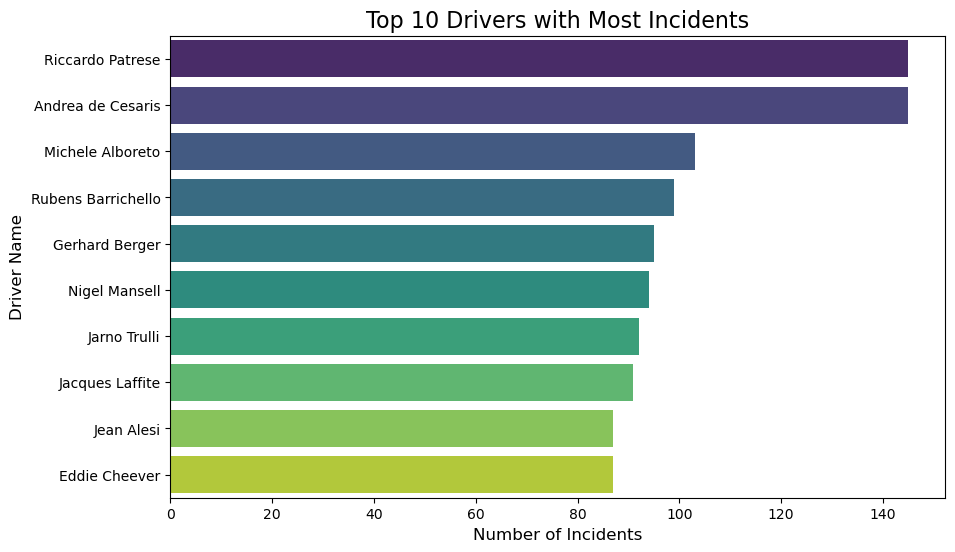

In [10]:
# List of incident statuses to filter the data
incident_statuses = [
    "Accident", "Collision", "Engine", "Gearbox", "Transmission", "Clutch", 
    "Hydraulics", "Electrical", "Spun off", "Radiator", "Suspension", 
    "Brakes", "Differential", "Overheating", "Mechanical", "Tyre", 
    "Driver Seat", "Puncture", "Driveshaft", "Retired", "Fuel pressure", 
    "Front wing", "Water pressure", "Refuelling", "Wheel", "Throttle", 
    "Steering", "Technical", "Electronics", "Broken wing", 
    "Heat shield fire", "Exhaust", "Oil leak", "Wheel rim", "Water leak", 
    "Fuel pump", "Track rod", "Oil pressure", "Engine fire", 
    "Engine misfire", "Tyre puncture", "Out of fuel", "Wheel nut", 
    "Not classified", "Pneumatics", "Handling", "Rear wing", "Fire", 
    "Wheel bearing", "Physical", "Fuel system", "Oil line", 
    "Fuel rig", "Launch control", "Injured", "Fuel", "Power loss", 
    "Vibrations", "Drivetrain", "Ignition", "Chassis", "Battery", 
    "Stalled", "Halfshaft", "Crankshaft", "Safety concerns", 
    "Alternator", "Underweight", "Safety belt", "Oil pump", 
    "Fuel leak", "Excluded", "Injection", "Distributor", "Driver unwell", 
    "Turbo", "CV joint", "Water pump", "Fatal accident", "Spark plugs", 
    "Fuel pipe", "Eye injury", "Oil pipe", "Axle", "Water pipe", 
    "Supercharger", "Collision damage", "Power Unit", "ERS", "Brake duct", 
    "Seat", "Damage", "Debris", "Illness", "Undertray", "Cooling system"
]

# Filter the data to only include incidents from the list of statuses
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count the number of incidents per driver by driverId
incidents_per_driver = incidents['driverId'].value_counts()

# Create a new column with the full name of the driver (forename and surname)
incidents_with_names = incidents['forename'] + ' ' + incidents['surname']

# Count the number of incidents by driver's full name
incidents_per_driver_name = incidents_with_names.value_counts()

# Display the top 10 drivers with the most incidents
top_10_incidents = incidents_per_driver_name.head(10)

# Create a horizontal bar chart for the top 10 drivers with the most incidents
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_incidents.values, y=top_10_incidents.index, palette='viridis', hue=top_10_incidents.index, legend=False)

# Add a title and axis labels to the plot
plt.title('Top 10 Drivers with Most Incidents', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Driver Name', fontsize=12)

# Display the plot
plt.show()

### Incident per starting position(grid position)

grid
15    476
14    465
13    455
17    455
16    452
18    450
11    449
10    448
12    444
19    439
20    437
8     405
9     404
6     388
7     384
5     377
4     352
21    350
22    325
3     318
2     294
1     278
23    235
24    230
25    165
26    146
0      56
27     29
28     16
29     15
30     14
31      8
32      7
33      3
34      1
Name: count, dtype: int64


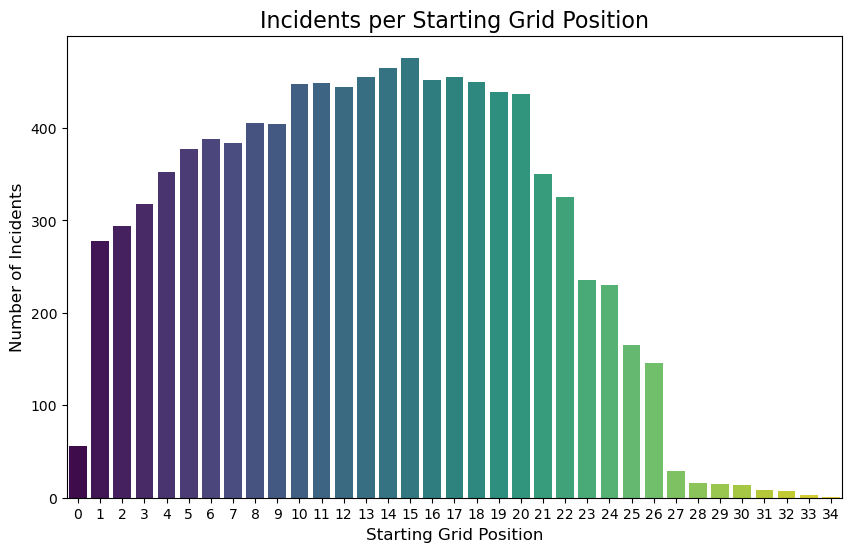

In [12]:
# Filter the data to only include incidents from the list of statuses
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count the number of incidents by starting grid position
incidents_per_grid = incidents['grid'].value_counts()

# Display the results
print(incidents_per_grid)

# Create a bar plot to visualize the number of incidents per starting grid position
plt.figure(figsize=(10, 6))
sns.barplot(x=incidents_per_grid.index, y=incidents_per_grid.values, hue=incidents_per_grid.index, palette='viridis', legend=False)

# Add a title and axis labels to the plot
plt.title('Incidents per Starting Grid Position', fontsize=16)
plt.xlabel('Starting Grid Position', fontsize=12)
plt.ylabel('Number of Incidents', fontsize=12)

# Display the plot
plt.show()

### Average points based on starting grid position

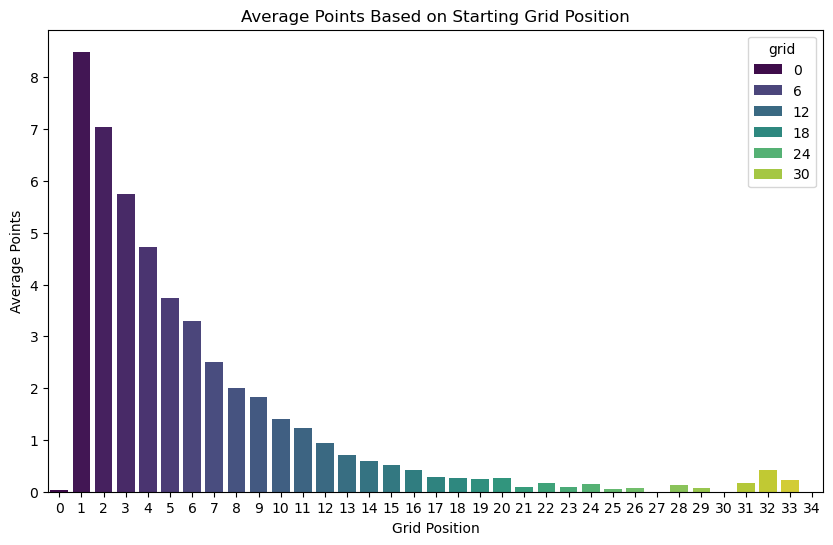

In [14]:
# Analyze the average points based on grid position
grid_points = filtered_data.groupby('grid')['points'].mean()

# Create a bar plot to visualize the average points based on grid position
plt.figure(figsize=(10, 6))
sns.barplot(x=grid_points.index, y=grid_points.values, palette='viridis', hue=grid_points.index)

# Add a title and axis labels to the plot
plt.title('Average Points Based on Starting Grid Position')
plt.xlabel('Grid Position')
plt.ylabel('Average Points')

# Display the plot
plt.show()

### Top 10 drivers with most wins

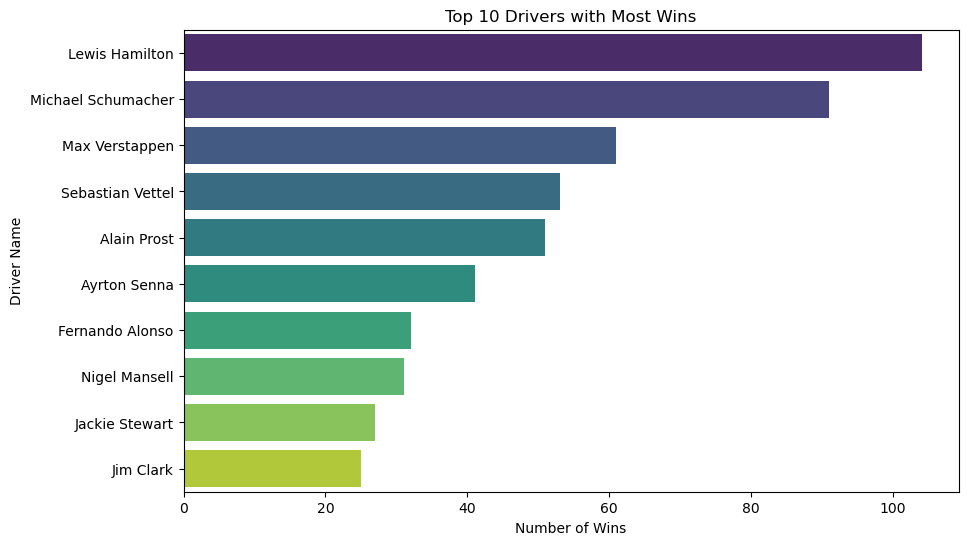

In [16]:
# Make a copy of filtered_data to avoid SettingWithCopyWarning
filtered_data = filtered_data.copy()

# Adding driver name to the copied dataset using .loc
filtered_data.loc[:, 'driver_name'] = filtered_data['forename'] + ' ' + filtered_data['surname']

# Counting wins per driver
wins_per_driver = filtered_data.groupby('driver_name')['positionText'].apply(lambda x: (x == '1').sum())

# Display top 10 drivers with the most wins
top_10_wins = wins_per_driver.sort_values(ascending=False).head(10)

# Visualization without FutureWarning
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_wins.values, y=top_10_wins.index, palette='viridis', hue=None)  # Correct usage of palette
plt.title('Top 10 Drivers with Most Wins')
plt.xlabel('Number of Wins')
plt.ylabel('Driver Name')
plt.show()

### Top 10 incidents by status

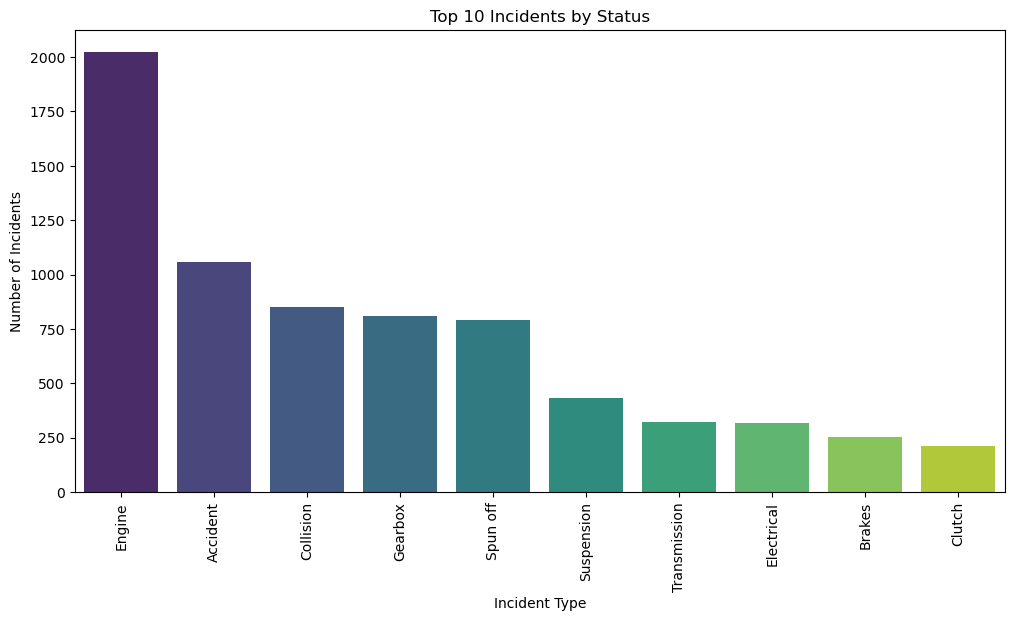

In [18]:
# Filter the data to include only incidents
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count the number of incidents by status
incident_counts = incidents['status'].value_counts()

# Filter the top 10 most frequent incidents
top_10_incident_counts = incident_counts.head(10)

# Visualization: Create a bar plot for the top 10 incidents by status
plt.figure(figsize=(12, 6))  # Set the size of the figure
sns.barplot(x=top_10_incident_counts.index, y=top_10_incident_counts.values, palette='viridis')  # Plot with color palette
plt.title('Top 10 Incidents by Status')  # Title of the plot
plt.xlabel('Incident Type')  # Label for the x-axis
plt.ylabel('Number of Incidents')  # Label for the y-axis
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

### Top 10 Circuits with Most Incidents

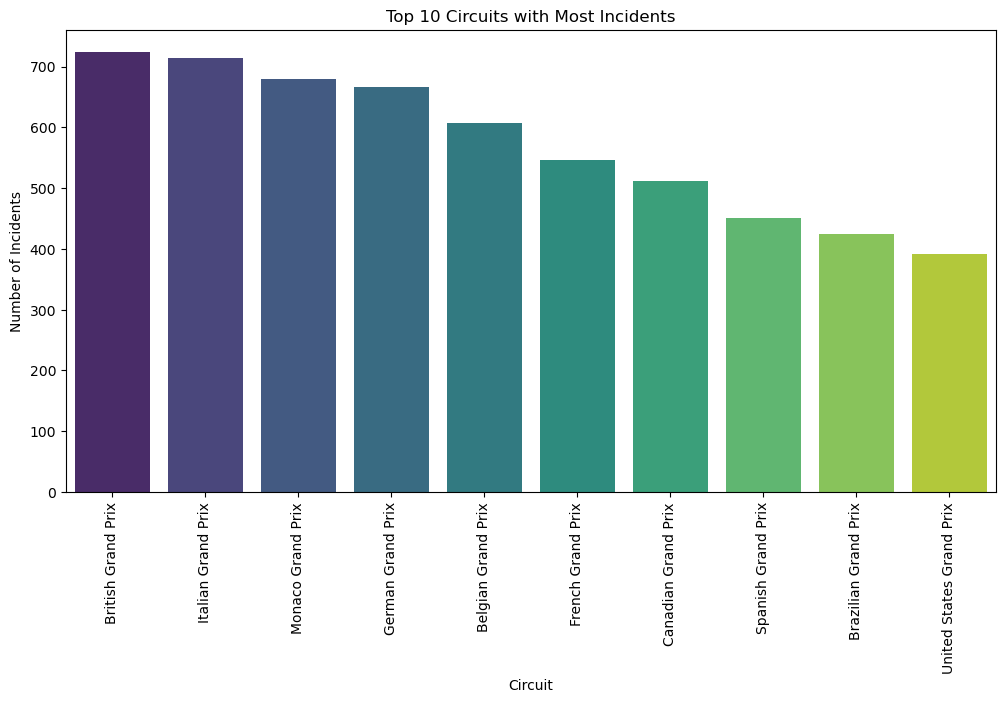

In [20]:
# Filter only incidents
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count incidents by circuit
incidents_per_circuit = incidents.groupby('name')['status'].count()

# Select the top 10 circuits with the most incidents
top_10_incidents_per_circuit = incidents_per_circuit.sort_values(ascending=False).head(10)

# Visualization
plt.figure(figsize=(12, 6))  # Set the size of the figure
sns.barplot(x=top_10_incidents_per_circuit.index, y=top_10_incidents_per_circuit.values, palette='viridis')  # Plot with color palette
plt.title('Top 10 Circuits with Most Incidents')  # Title of the plot
plt.xlabel('Circuit')  # Label for the x-axis
plt.ylabel('Number of Incidents')  # Label for the y-axis
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()  # Display the plot

### Incident per number of laps

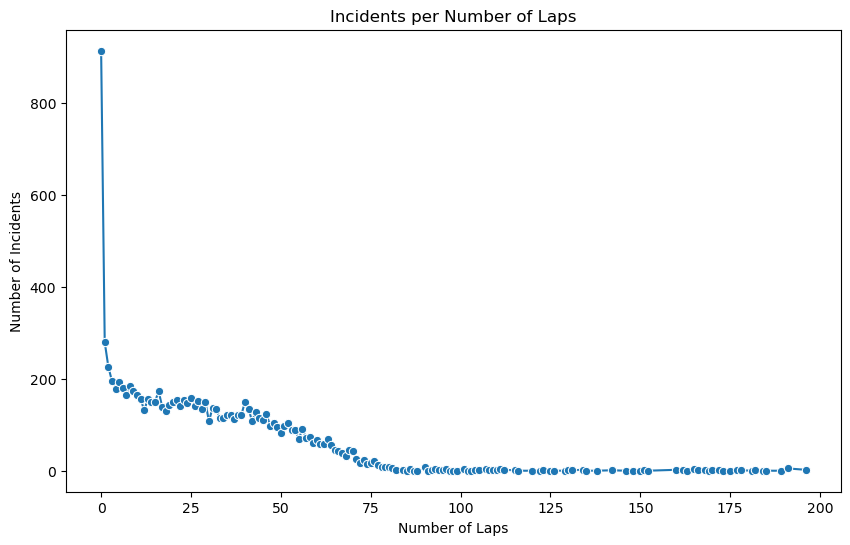

In [22]:
# Filter only incidents
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count incidents by number of laps
incidents_per_laps = incidents.groupby('laps')['status'].count()

# Visualization
plt.figure(figsize=(10, 6))  # Set the size of the figure
sns.lineplot(x=incidents_per_laps.index, y=incidents_per_laps.values, marker='o')  # Plot the line with markers
plt.title('Incidents per Number of Laps')  # Title of the plot
plt.xlabel('Number of Laps')  # Label for the x-axis
plt.ylabel('Number of Incidents')  # Label for the y-axis
plt.show()  # Display the plot

### Incidents vs Points per driver

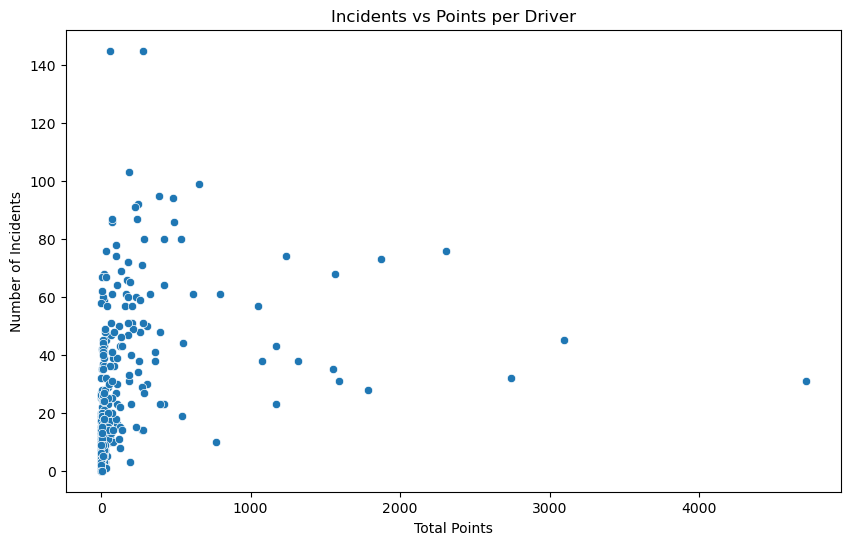

In [24]:
# Create a new DataFrame for drivers and their points
driver_points = filtered_data.groupby('driverId')['points'].sum()

# Count incidents by driver
incidents_per_driver = filtered_data[filtered_data['status'].isin(incident_statuses)].groupby('driverId').size()

# Combine points and the number of incidents into one DataFrame
driver_incidents_points = pd.DataFrame({
    'points': driver_points,
    'incidents': incidents_per_driver
}).fillna(0)  # If some drivers have no incidents, fill with 0

# Visualize the correlation between the number of incidents and the points scored
plt.figure(figsize=(10, 6))
sns.scatterplot(x=driver_incidents_points['points'], y=driver_incidents_points['incidents'])
plt.title('Incidents vs Points per Driver')  # Title of the plot
plt.xlabel('Total Points')  # Label for the x-axis
plt.ylabel('Number of Incidents')  # Label for the y-axis
plt.show()  # Display the plot

### Incidents per year

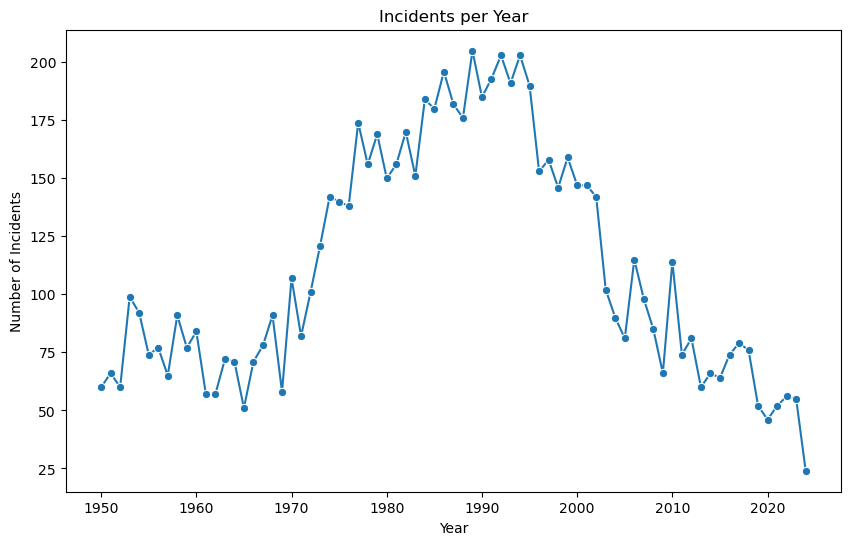

In [31]:
# Filter incidents only
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Count incidents by year
incidents_per_year = incidents.groupby('year')['status'].count()

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x=incidents_per_year.index, y=incidents_per_year.values, marker='o')  # Removed the 'palette' argument
plt.title('Incidents per Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.show()


### wins per year and point per year plots

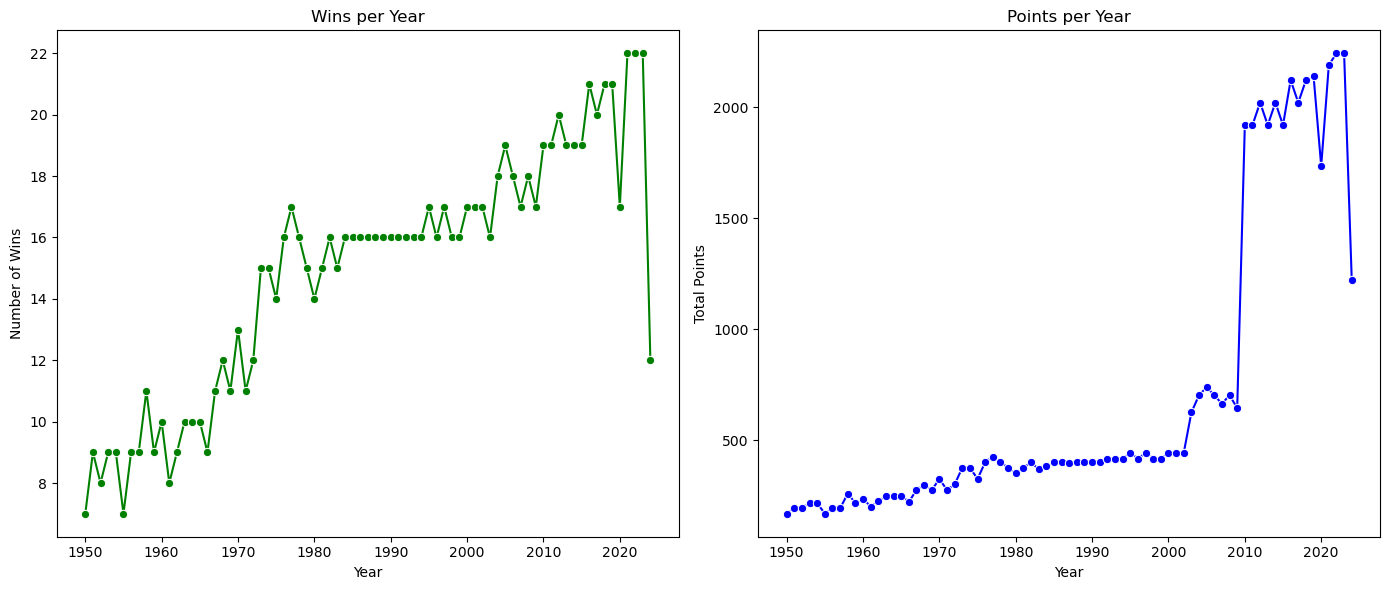

In [33]:
# Number of wins per year
wins_per_year = filtered_data[filtered_data['positionText'] == '1'].groupby('year')['positionText'].count()

# Number of points per year
points_per_year = filtered_data.groupby('year')['points'].sum()

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Wins
sns.lineplot(x=wins_per_year.index, y=wins_per_year.values, ax=ax[0], marker='o', color='green')
ax[0].set_title('Wins per Year')  
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Number of Wins')

# Points
sns.lineplot(x=points_per_year.index, y=points_per_year.values, ax=ax[1], marker='o', color='blue')
ax[1].set_title('Points per Year')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Total Points')

plt.tight_layout()
plt.show()

#### Wins by grid position

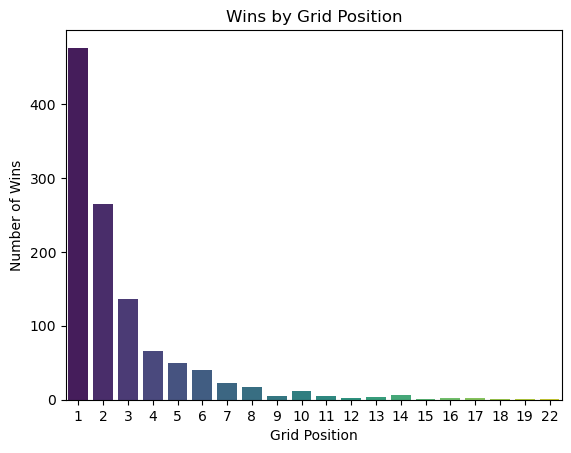

In [35]:
wins_by_grid = filtered_data[filtered_data['positionText'] == '1'].groupby('grid').size()
sns.barplot(x=wins_by_grid.index, y=wins_by_grid.values, palette='viridis')
plt.title('Wins by Grid Position')
plt.xlabel('Grid Position')
plt.ylabel('Number of Wins')
plt.show()


In [48]:
print(filtered_data.columns)

Index(['raceId', 'year', 'circuitId', 'name', 'resultId', 'driverId',
       'constructorId', 'grid', 'positionText', 'positionOrder', 'points',
       'laps', 'time_y', 'milliseconds', 'fastestLap', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status',
       'driver_name'],
      dtype='object')


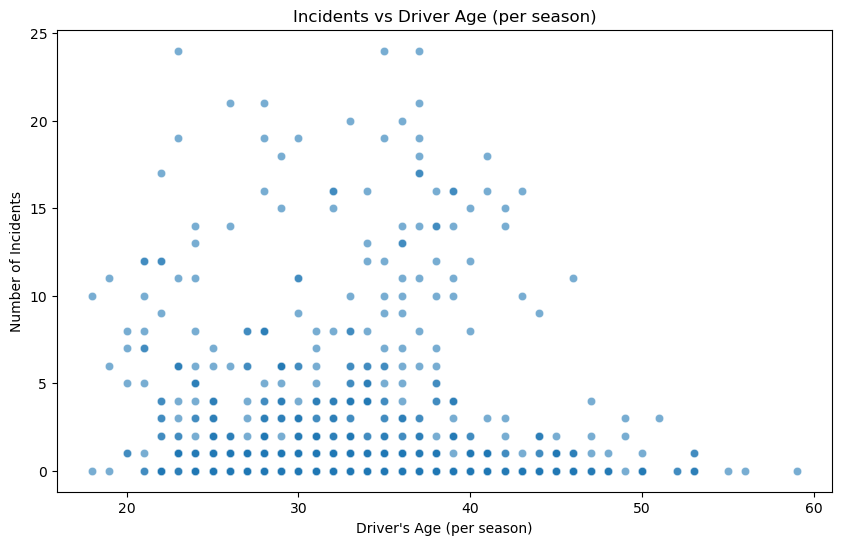

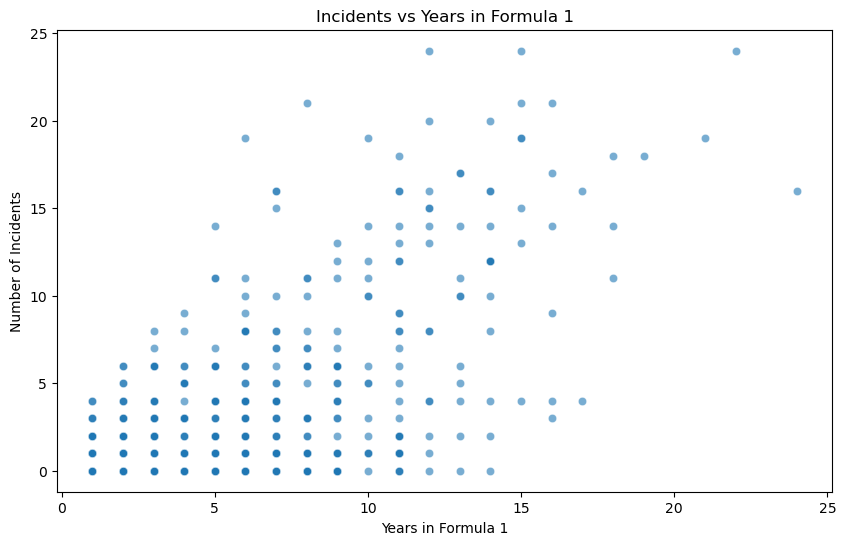

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded the data into filtered_data

# Step 1: Calculate the driver's age for each year in the dataset
filtered_data['dob'] = pd.to_datetime(filtered_data['dob'])
filtered_data['age_in_season'] = filtered_data['year'] - filtered_data['dob'].dt.year

# Step 2: Calculate the number of years in Formula 1 for each driver
# First, identify the first and last race year for each driver
first_race_year = filtered_data.groupby('driverId')['year'].min()
last_race_year = filtered_data.groupby('driverId')['year'].max()

# Calculate years in Formula 1 by subtracting first race year from last race year and adding 1
years_in_f1 = last_race_year - first_race_year + 1

# Step 3: Calculate incidents per driver
incident_statuses = ['Collision', 'Retired', 'Accident', 'Off track', 'Mechanical failure']  # Example, adjust as needed
incidents = filtered_data[filtered_data['status'].isin(incident_statuses)]

# Counting incidents per driver
incidents_per_driver = incidents.groupby('driverId').size()

# Merge incident count with driver data
driver_experience_incidents = pd.DataFrame({
    'incidents': incidents_per_driver,
    'age_in_season': filtered_data.groupby('driverId')['age_in_season'].first(),  # Use first age entry for the driver
    'years_in_f1': years_in_f1
}).fillna(0)  # Filling any missing incidents with 0 if a driver has no incidents

# Step 4: Visualization - Scatter plot of incidents vs. Age or Years in F1

# Scatter plot for incidents vs. age in season
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age_in_season', y='incidents', data=driver_experience_incidents, alpha=0.6)
plt.title("Incidents vs Driver Age (per season)")
plt.xlabel("Driver's Age (per season)")
plt.ylabel("Number of Incidents")
plt.show()

# Scatter plot for incidents vs. Years in F1
plt.figure(figsize=(10, 6))
sns.scatterplot(x='years_in_f1', y='incidents', data=driver_experience_incidents, alpha=0.6)
plt.title("Incidents vs Years in Formula 1")
plt.xlabel("Years in Formula 1")
plt.ylabel("Number of Incidents")
plt.show()

### descriptive statistics and cleanup, preprocessing

1. Data cleanup

In [12]:
# Check for missing values in the dataset
filtered_data.isnull().sum()

# Remove rows with missing values
filtered_data = filtered_data.dropna()

# Check for duplicates
filtered_data = filtered_data.drop_duplicates()

# Check data types
filtered_data.dtypes

raceId               int64
year                 int64
circuitId            int64
name                object
resultId             int64
driverId             int64
constructorId        int64
grid                 int64
positionText        object
positionOrder        int64
points             float64
laps                 int64
time_y              object
dob                 object
milliseconds        object
fastestLap          object
fastestLapTime      object
fastestLapSpeed     object
statusId             int64
forename            object
surname             object
status              object
dtype: object

- descriptive statistics

In [14]:
# Descriptive statistics for numerical variables
numeric_columns = filtered_data.select_dtypes(include=['int64', 'float64']).columns
descriptive_stats_numeric = filtered_data[numeric_columns].describe()

# Display the results
print(descriptive_stats_numeric)

             raceId          year     circuitId      resultId      driverId  \
count  26519.000000  26519.000000  26519.000000  26519.000000  26519.000000   
mean     546.376560   1991.099287     23.684943  13260.940986    274.357291   
std      309.642244     19.799290     18.973790   7656.813206    279.275606   
min        1.000000   1950.000000      1.000000      1.000000      1.000000   
25%      298.000000   1977.000000      9.000000   6630.500000     57.000000   
50%      527.000000   1991.000000     18.000000  13260.000000    170.000000   
75%      803.000000   2008.000000     34.000000  19889.500000    385.000000   
max     1132.000000   2024.000000     80.000000  26524.000000    860.000000   

       constructorId          grid  positionOrder        points          laps  \
count   26519.000000  26519.000000   26519.000000  26519.000000  26519.000000   
mean       49.801161     11.145820      12.814812      1.959578     46.228251   
std        61.091426      7.213453       7.67

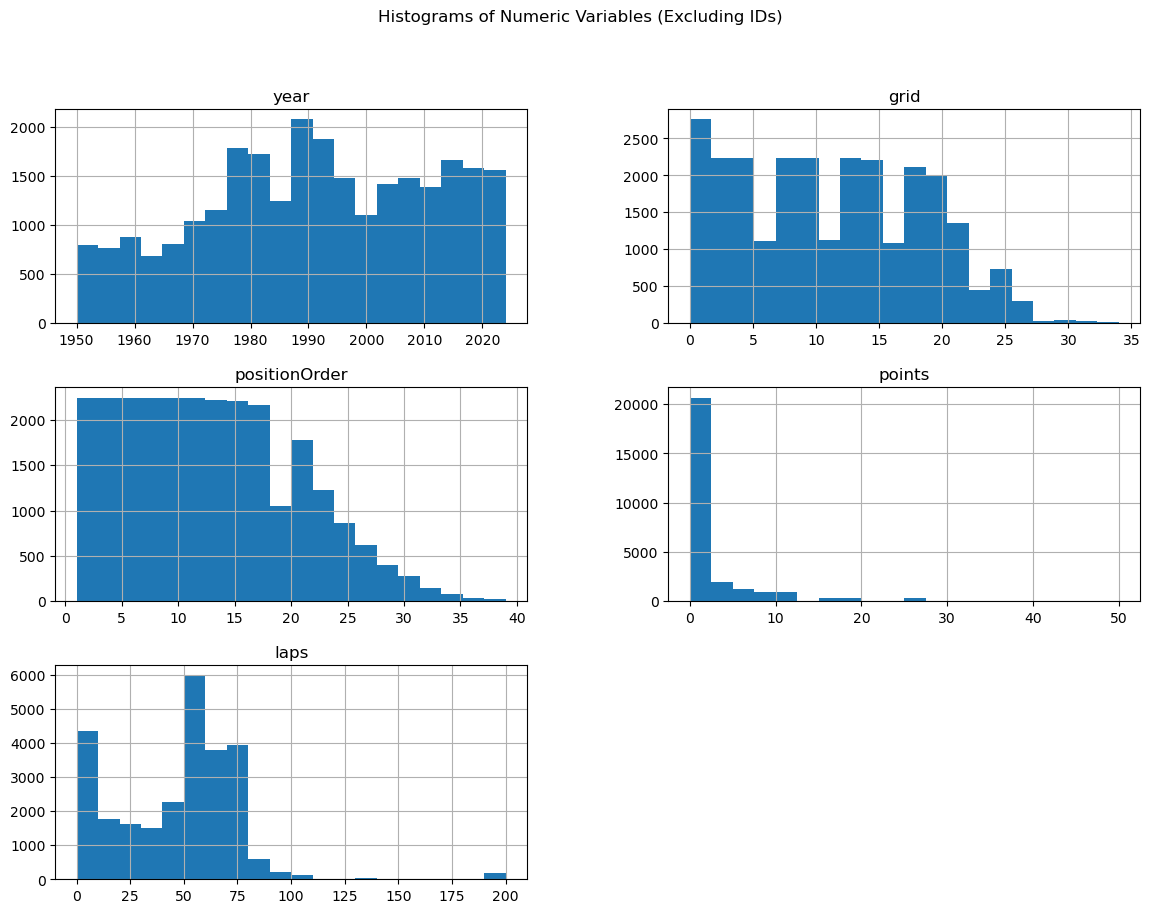

In [16]:
# Exclude columns likely to be IDs (e.g., 'driverId', 'raceId', etc.)
exclude_columns = ['driverId', 'raceId', 'constructorId','circuitId', 'resultId','statusId']  # Adjust based on your dataset
numeric_columns_filtered = [col for col in numeric_columns if col not in exclude_columns]

# Histogram for numerical variables excluding IDs
filtered_data[numeric_columns_filtered].hist(bins=20, figsize=(14, 10))
plt.suptitle('Histograms of Numeric Variables (Excluding IDs)')
plt.show()


- through descriptive statistics, I discovered that there are a lot of lines that contain grid = 0. Through further research, I came to the conclusion that this means that the person did not even participate in the race, so those lines are not important for the analysis of the incident.

### DO THIS STEP AFTER MAKING GRID_LEVEL

In [34]:
# First, count the number of rows before removal
before_removal = len(filtered_data)

# Filter the data to keep only rows where grid is not 0
filtered_data = filtered_data[filtered_data['grid'] != 0]

# Count the number of rows after removal
after_removal = len(filtered_data)

# Display the number of removed rows
removed_rows = before_removal - after_removal
print(f'Number of rows removed: {removed_rows}')

# Check the first few rows to make sure rows with grid = 0 are removed
print(filtered_data.head())

Number of rows removed: 1631
   raceId  year  circuitId                   name  resultId  driverId  \
0       1  2009          1  Australian Grand Prix      7554        18   
1       1  2009          1  Australian Grand Prix      7555        22   
2       1  2009          1  Australian Grand Prix      7556        15   
3       1  2009          1  Australian Grand Prix      7557        10   
4       1  2009          1  Australian Grand Prix      7558         4   

   constructorId  grid positionText  positionOrder  ...  milliseconds  \
0             23     1            1              1  ...       5655784   
1             23     2            2              2  ...       5656591   
2              7    20            3              3  ...       5657388   
3              7    19            4              4  ...       5660219   
4              4    10            5              5  ...       5660663   

   fastestLap fastestLapTime fastestLapSpeed statusId  forename      surname  \
0          17

In [36]:
# Compute descriptive statistics
descriptive_stats = filtered_data.describe(include=['object', 'category'])
print(descriptive_stats)

                      name positionText time_y milliseconds fastestLap  \
count                24888        24888  24888        24888      24888   
unique                  54           39   7253         7473         81   
top     British Grand Prix            R     \N           \N         \N   
freq                  1757         8864  17375        17375      16930   

       fastestLapTime fastestLapSpeed forename     surname    status  \
count           24888           24888    24888       24888     24888   
unique           7248            7459      452         739       134   
top                \N              \N   Carlos  Schumacher  Finished   
freq            16930           16930      425         531      7508   

            driver_name  
count             24888  
unique              790  
top     Fernando Alonso  
freq                391  


### adding driver skill to the dataset

- I added driver skill by calculating the number of points for each driver for each of his seasons and dividing that by the number of seasons he participated in to get the average number of points that driver won. That average number of points was then an indicator for me as to which driver I would give the driver skill to. I used three skill categories, which were 3, 2 and 1. Category 3 indicates high skilled drivers, category 2 indicates medium skilled drivers, and category 1 indicates low skilled drivers.

In [22]:
# Step 1: Calculate average points per season for each driver
driver_performance = filtered_data.groupby('driverId').agg(
    total_points=('points', 'sum'),
    total_seasons=('year', 'nunique')
).reset_index()

driver_performance['avg_points_per_season'] = driver_performance['total_points'] / driver_performance['total_seasons']

# Step 2: Add skill level based on average points per season
high_threshold = driver_performance['avg_points_per_season'].quantile(0.9)  # Top 10%
low_threshold = driver_performance['avg_points_per_season'].quantile(0.3)  # Bottom 30%

driver_performance['driver_skill'] = driver_performance['avg_points_per_season'].apply(
    lambda x: 3 if x >= high_threshold else (1 if x <= low_threshold else 2)
)

# Step 3: Merge driver skill into the merged dataset
filtered_data = filtered_data.merge(driver_performance[['driverId', 'driver_skill']], on='driverId', how='left')

# Check the results
print(filtered_data[['driverId', 'year', 'grid', 'positionOrder', 'status', 'driver_skill']].head())


   driverId  year  grid  positionOrder    status  driver_skill
0        18  2009     1              1  Finished             3
1        22  2009     2              2  Finished             3
2        15  2009    20              3  Finished             3
3        10  2009    19              4  Finished             2
4         4  2009    10              5  Finished             3


In [24]:
print(filtered_data)

       raceId  year  circuitId                   name  resultId  driverId  \
0           1  2009          1  Australian Grand Prix      7554        18   
1           1  2009          1  Australian Grand Prix      7555        22   
2           1  2009          1  Australian Grand Prix      7556        15   
3           1  2009          1  Australian Grand Prix      7557        10   
4           1  2009          1  Australian Grand Prix      7558         4   
...       ...   ...        ...                    ...       ...       ...   
26514    1132  2024          9     British Grand Prix     26520       839   
26515    1132  2024          9     British Grand Prix     26521       815   
26516    1132  2024          9     British Grand Prix     26522       855   
26517    1132  2024          9     British Grand Prix     26523       847   
26518    1132  2024          9     British Grand Prix     26524       842   

       constructorId  grid positionText  positionOrder  ...         dob  \


### adding grid_level

- then it was necessary to add grid_level which will indicate which grid positions are in which risk category, i.e. if the grid position is in category 3 then it is high risk for an incident, if it is in 2 then it is medium risk for an incident, and if it is in 1 then it is low risk for an incident

In [26]:
# Izračunavamo broj incidenata na svakoj grid poziciji
incidents_by_grid = filtered_data[filtered_data['status'].isin(incident_statuses)].groupby('grid')['status'].count()

# Ukupan broj vožnji na svakoj grid poziciji
total_by_grid = filtered_data.groupby('grid')['status'].count()

# Vjerojatnost incidenta na svakoj grid poziciji
probability_of_incident = incidents_by_grid / total_by_grid

# Prikazujemo rezultate
print(probability_of_incident)

grid
0     0.034335
1     0.247331
2     0.264151
3     0.284436
4     0.314286
5     0.336607
6     0.348607
7     0.341941
8     0.362578
9     0.360714
10    0.400716
11    0.400893
12    0.398206
13    0.408805
14    0.419675
15    0.432334
16    0.415441
17    0.422862
18    0.433109
19    0.430392
20    0.450980
21    0.502152
22    0.495427
23    0.518764
24    0.536131
25    0.548173
26    0.588710
27    0.630435
28    0.533333
29    0.600000
30    0.736842
31    0.444444
32    0.411765
33    0.230769
34    1.000000
Name: status, dtype: float64


In [32]:
# Filter out grid positions where grid == 0
filtered_probability_of_incident = probability_of_incident[probability_of_incident.index != 0]

# Define thresholds for incident probability categorization
high_threshold = filtered_probability_of_incident.quantile(0.9)  # Top 10% probability
low_threshold = filtered_probability_of_incident.quantile(0.3)  # Bottom 30% probability

# Add risk category for each grid position
def categorize_grid_risk(probability):
    if probability >= high_threshold:
        return 3
    elif probability <= low_threshold:
        return 2
    else:
        return 1

# Apply the function to calculate grid risk categories
grid_risk_categories = filtered_probability_of_incident.apply(categorize_grid_risk)

# Show categorized grid positions
print(grid_risk_categories)


grid
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    3
28    1
29    3
30    3
31    1
32    1
33    2
34    3
Name: status, dtype: int64


In [34]:
# Dodajemo grid risk level u filtered_data prema grid poziciji
filtered_data['grid_risk'] = filtered_data['grid'].map(grid_risk_categories)

# Provjeravamo rezultate
print(filtered_data[['raceId', 'driverId', 'grid', 'grid_risk']].head())

   raceId  driverId  grid  grid_risk
0       1        18     1          2
1       1        22     2          2
2       1        15    20          1
3       1        10    19          1
4       1         4    10          1


In [36]:
# Dodavanje varijable 'incident_occurred' na temelju statusa
filtered_data['incident_occurred'] = filtered_data['status'].apply(
    lambda x: 1 if x in incident_statuses else 0
)

# Provjera rezultata
print(filtered_data[['status', 'incident_occurred']].head())


     status  incident_occurred
0  Finished                  0
1  Finished                  0
2  Finished                  0
3  Finished                  0
4  Finished                  0


In [51]:
print(filtered_data.columns)

Index(['raceId', 'year', 'circuitId', 'name', 'resultId', 'driverId',
       'constructorId', 'grid', 'positionText', 'positionOrder', 'points',
       'laps', 'time_y', 'milliseconds', 'fastestLap', 'fastestLapTime',
       'fastestLapSpeed', 'statusId', 'forename', 'surname', 'status',
       'driver_name', 'positionChange', 'driver_skill', 'grid_risk',
       'incident_occurred'],
      dtype='object')


In [38]:
from sklearn.utils import resample

# Podijelimo dataset na dvije klase
df_no = filtered_data[filtered_data['incident_occurred'] == 0]
df_yes = filtered_data[filtered_data['incident_occurred'] == 1]

# Resample (under-sampling) No slučajeva da ih bude isto koliko i Yes slučajeva
df_no_undersampled = resample(df_no, 
                              replace=False,    # Bez vraćanja, samo uzimamo uzorke
                              n_samples=len(df_yes), # Koliko imamo Yes slučajeva
                              random_state=42)    # Za reproducibilnost

# Spajanje oba skupa podataka
df_balanced = pd.concat([df_yes, df_no_undersampled])
print(df_balanced)


       raceId  year  circuitId                      name  resultId  driverId  \
12          1  2009          1     Australian Grand Prix      7566        20   
13          1  2009          1     Australian Grand Prix      7567         9   
14          1  2009          1     Australian Grand Prix      7568         8   
15          1  2009          1     Australian Grand Prix      7569        13   
16          1  2009          1     Australian Grand Prix      7570        12   
...       ...   ...        ...                       ...       ...       ...   
1138       55  2006          1     Australian Grand Prix       799        34   
5223      246  1995          8         French Grand Prix      4884        49   
18083     728  1963         56  South African Grand Prix     20300       373   
15064     592  1974         30  South African Grand Prix     14589       296   
941        46  2007         11      Hungarian Grand Prix       602        25   

       constructorId  grid positionText

grid_risk nije normalno distribuiran (p-value = 0.0)
driver_skill nije normalno distribuiran (p-value = 0.0)
incident_occurred nije normalno distribuiran (p-value = 0.0)

Rezultati korelacije između varijabli:
grid_risk: Spearman korelacija = -0.1202737928711867, p-vrijednost = 1.6193653722243826e-63
driver_skill: Spearman korelacija = -0.20399796189536484, p-vrijednost = 1.3962335840387504e-181
incident_occurred: Spearman korelacija = 0.9999999999999998, p-vrijednost = 0.0


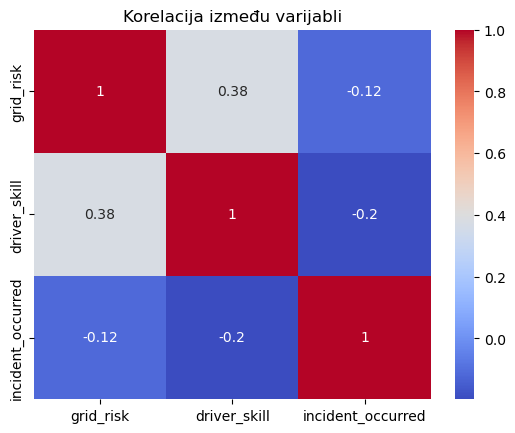

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest, pearsonr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Funkcija za provjeru normalnosti i izračun korelacije
def check_normality_and_corr(df):
    # Testiranje normalnosti za 'grid_risk', 'driver_skill', i 'incident_occurred'
    variables = ['grid_risk', 'driver_skill', 'incident_occurred']
    results = {}

    for var in variables:
        # Kolmogorov-Smirnov test za normalnost
        stat, p_value = normaltest(df[var].dropna())
        if p_value > 0.05:
            print(f"{var} je normalno distribuiran (p-value = {p_value})")
            # Pearsonova korelacija
            corr, p_val = pearsonr(df[var], df['incident_occurred'])
            results[var] = {'test': 'Pearson', 'correlation': corr, 'p-vrijednost': p_val}
        else:
            print(f"{var} nije normalno distribuiran (p-value = {p_value})")
            # Spearmanova korelacija
            corr, p_val = spearmanr(df[var], df['incident_occurred'])
            results[var] = {'test': 'Spearman', 'correlation': corr, 'p-vrijednost': p_val}
    
    return results

# Primjena funkcije na vašu grupu podataka
results = check_normality_and_corr(df_balanced)

# Ispis rezultata korelacije
print("\nRezultati korelacije između varijabli:")
for var, result in results.items():
    print(f"{var}: {result['test']} korelacija = {result['correlation']}, p-vrijednost = {result['p-vrijednost']}")

# Vizualizacija korelacija
corr_matrix = df_balanced[['grid_risk', 'driver_skill', 'incident_occurred']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Korelacija između varijabli")
plt.show()


In [42]:
import statsmodels.api as sm

# Ovisna varijabla: incident_occurred (0 ili 1)
# Neovisne varijable: numeričke varijable poput 'grid_position', 'driver_skill'
X = df_balanced[['grid_risk', 'driver_skill']]  # Neovisne varijable
y = df_balanced['incident_occurred']  # Ovisna varijabla

# Dodajte konstantnu vrijednost (intercept)
X = sm.add_constant(X)

# Izgradnja Logit modela
model = sm.Logit(y, X)
result = model.fit()

# Prikaz rezultata
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.672443
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:      incident_occurred   No. Observations:                19428
Model:                          Logit   Df Residuals:                    19425
Method:                           MLE   Df Model:                            2
Date:                Fri, 10 Jan 2025   Pseudo R-squ.:                 0.02987
Time:                        19:16:45   Log-Likelihood:                -13064.
converged:                       True   LL-Null:                       -13466.
Covariance Type:            nonrobust   LLR p-value:                2.028e-175
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.6422      0.062     26.526      0.000       1.521       1.764
grid_risk       -0.2023

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Podjela na treniranje i testiranje
X = df_balanced[['grid_risk', 'driver_skill']]
y = df_balanced['incident_occurred']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Izrada modela
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluacija modela
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.60      0.61      0.61      2885
           1       0.61      0.61      0.61      2944

    accuracy                           0.61      5829
   macro avg       0.61      0.61      0.61      5829
weighted avg       0.61      0.61      0.61      5829



In [131]:
print(df_simulated)

       raceId  year  circuitId                   name  resultId  driverId  \
12          1  2009          1  Australian Grand Prix      7566        20   
13          1  2009          1  Australian Grand Prix      7567         9   
14          1  2009          1  Australian Grand Prix      7568         8   
15          1  2009          1  Australian Grand Prix      7569        13   
34          2  2009          2   Malaysian Grand Prix      7588        20   
...       ...   ...        ...                    ...       ...       ...   
2943      143  2001         18   Brazilian Grand Prix      2609        58   
14440     615  1973         20      German Grand Prix     15209       329   
17558     769  1958         13     Belgian Grand Prix     18592       455   
8619      380  1988         10      German Grand Prix      8752       146   
2087      101  2004         10      German Grand Prix      1749        45   

       constructorId  grid positionText  positionOrder  ...  fastestLapSpee

Accuracy: 0.61
Confusion Matrix:
[[1758 1127]
 [1153 1791]]


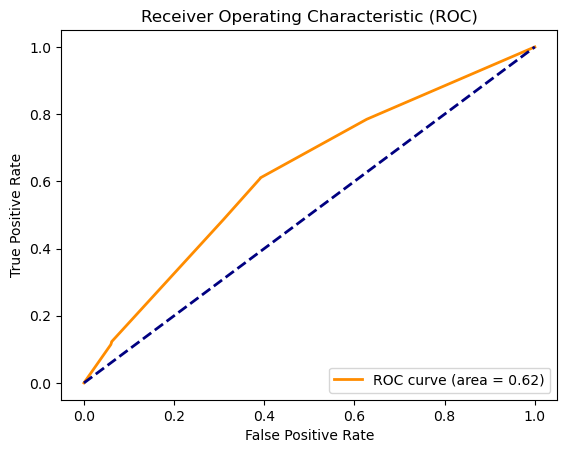

AUC: 0.62


In [46]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Predviđanje na testnim podacima
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]  # prednosti za klasu "1" (incident)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.2f}")


Accuracy: 0.61
Confusion Matrix:
[[1754 1131]
 [1146 1798]]


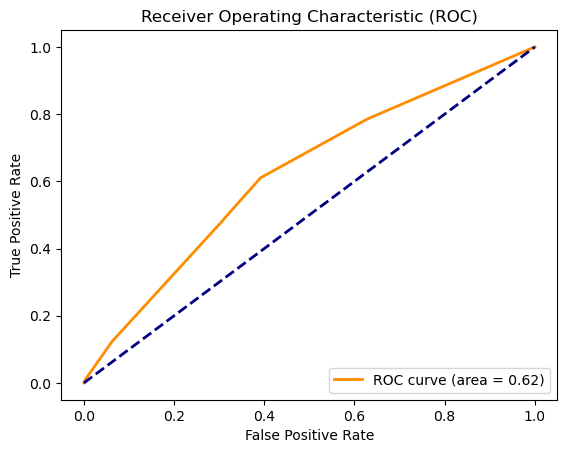

AUC: 0.62
Feature Importance:
grid_risk: 0.2438
driver_skill: 0.7562


'\n# Uklanjanje manje važnih varijabli na temelju Feature Importance\n# Ako želite optimizirati model, možete ukloniti varijable koje imaju malu važnost:\n# Na primjer, možemo postaviti prag za značajnost varijabli.\nthreshold = 0.05  # Svi varijable s manjim značajem bit će uklonjene\nimportant_features = X.columns[rf_model.feature_importances_ > threshold]\n\n# Ponovno treniranje modela s važnim varijablama\nX_train_important = X_train[important_features]\nX_test_important = X_test[important_features]\n\nrf_model_optimized = RandomForestClassifier(random_state=42)\nrf_model_optimized.fit(X_train_important, y_train)\n\n# Predviđanje i evaluacija optimiziranog modela\ny_pred_optimized = rf_model_optimized.predict(X_test_important)\ny_pred_prob_optimized = rf_model_optimized.predict_proba(X_test_important)[:, 1]\n\naccuracy_optimized = accuracy_score(y_test, y_pred_optimized)\nprint(f"Optimized Accuracy: {accuracy_optimized:.2f}")\n\n# Confusion Matrix za optimizirani model\ncm_optimize

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Podjela na trening i test skup
X = df_balanced[['grid_risk', 'driver_skill']]  # Ovo su nezavisne varijable
y = df_balanced['incident_occurred']  # Ovisna varijabla (incident_occurred)

# Podjela na treniranje i testiranje
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Izrada Random Forest modela
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Predviđanje na testnim podacima
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Evaluacija modela
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc_score:.2f}")

# Ispisivanje važnosti varijabli
print("Feature Importance:")
for feature, importance in zip(X.columns, rf_model.feature_importances_):
    print(f"{feature}: {importance:.4f}")
"""
# Uklanjanje manje važnih varijabli na temelju Feature Importance
# Ako želite optimizirati model, možete ukloniti varijable koje imaju malu važnost:
# Na primjer, možemo postaviti prag za značajnost varijabli.
threshold = 0.05  # Svi varijable s manjim značajem bit će uklonjene
important_features = X.columns[rf_model.feature_importances_ > threshold]

# Ponovno treniranje modela s važnim varijablama
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

rf_model_optimized = RandomForestClassifier(random_state=42)
rf_model_optimized.fit(X_train_important, y_train)

# Predviđanje i evaluacija optimiziranog modela
y_pred_optimized = rf_model_optimized.predict(X_test_important)
y_pred_prob_optimized = rf_model_optimized.predict_proba(X_test_important)[:, 1]

accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Optimized Accuracy: {accuracy_optimized:.2f}")

# Confusion Matrix za optimizirani model
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print("Optimized Confusion Matrix:")
print(cm_optimized)

# ROC Curve za optimizirani model
fpr_optimized, tpr_optimized, thresholds_optimized = roc_curve(y_test, y_pred_prob_optimized)
plt.figure()
plt.plot(fpr_optimized, tpr_optimized, color='darkorange', lw=2, label='Optimized ROC curve (area = %0.2f)' % auc(fpr_optimized, tpr_optimized))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Optimized Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# AUC za optimizirani model
auc_score_optimized = roc_auc_score(y_test, y_pred_prob_optimized)
print(f"Optimized AUC: {auc_score_optimized:.2f}")
"""

In [64]:
# Get unique grid positions within each risk category
unique_grid_by_risk = filtered_data.groupby('grid_risk')['grid'].unique()

# Display the result
print(unique_grid_by_risk[1])


[20 19 10 13 17 16 15 14 11 12 18 22 21 23 24 25 26 28 31 32]


In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the risk positions based on the earlier example
risk_positions = {
    3: [27, 29, 30, 34],  # High risk
    2: [1, 2, 5, 9, 8, 3, 4, 7, 6, 33],  # Medium risk
    1: [20, 19, 10, 13, 17, 16, 15, 14, 11, 12, 18, 22, 21, 23, 24, 25, 26, 28, 31, 32]  # Low risk
}

# Function to calculate incident probability with handling for dynamic base probability
def calculate_incident_probability(row, base_probability=0.25):
    """
    Calculate the probability of an incident based on grid risk and driver skill.
    Args:
        row (pd.Series): Row of the dataframe containing grid_risk and driver_skill.
        base_probability (float): Base probability of an incident.
        
    Returns:
        float: Total probability of an incident.
    """
    # Increase the chance based on grid_risk
    risk_multiplier = 0.1 * row['grid_risk']  # Higher grid_risk increases the chance

    # Decrease the chance based on skill level (lower skill means higher probability of incident)
    skill_multiplier = 0.05 * (3 - row['driver_skill'])  # Lower skill increases the chance

    # Calculate total incident probability
    total_probability = base_probability + risk_multiplier + skill_multiplier

    # Ensure probability is within the range [0, 1]
    total_probability = min(max(total_probability, 0), 1)

    return total_probability

# Function to simulate the movement of drivers
def simulate_position_change(df, risk_positions):
    # Split drivers by their skill levels
    high_skill = df[df['driver_skill'] == 3].copy()
    medium_skill = df[df['driver_skill'] == 2].copy()
    low_skill = df[df['driver_skill'] == 1].copy()

    # Create new grid_risk positions by repeating each skill level's risk positions
    high_positions = np.tile(risk_positions[3], len(high_skill) // len(risk_positions[3]) + 1)[:len(high_skill)]
    medium_positions = np.tile(risk_positions[2], len(medium_skill) // len(risk_positions[2]) + 1)[:len(medium_skill)]
    low_positions = np.tile(risk_positions[1], len(low_skill) // len(risk_positions[1]) + 1)[:len(low_skill)]

    # Assign new grid_risk positions to drivers
    high_skill['grid_risk'] = 3
    medium_skill['grid_risk'] = 2
    low_skill['grid_risk'] = 1

    # Combine all drivers into a new DataFrame
    new_df = pd.concat([high_skill, medium_skill, low_skill])

    # Add random incident probability based on skill and position risk
    def random_incident(row):
        # Calculate the total incident probability
        total_probability = calculate_incident_probability(row)

        # Randomly choose 0 or 1 based on the total probability
        return np.random.choice([0, 1], p=[1 - total_probability, total_probability])

    # Apply the function to the DataFrame
    new_df['incident_occurred'] = new_df.apply(random_incident, axis=1)

    return new_df

# Simulate the movement of drivers and add incident information
df_simulated = simulate_position_change(df_balanced, risk_positions)

# Check the 'grid_risk' and 'incident_occurred' columns to see how they look
print(df_simulated[['driverId', 'grid_risk', 'driver_skill', 'incident_occurred']].head())

# Split the data into training and testing sets
X = df_simulated[['grid_risk', 'driver_skill']]  # Features: grid_risk and driver_skill
y = df_simulated['incident_occurred']  # Target variable: incident_occurred
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)  # Train the model
y_pred = model.predict(X_test)  # Predict on the test set

# Evaluate the model performance
print(classification_report(y_test, y_pred))  # Print classification report for evaluation

    driverId  grid_risk  driver_skill  incident_occurred
12        20          3             3                  1
13         9          3             3                  1
14         8          3             3                  1
15        13          3             3                  1
18         5          3             3                  0
              precision    recall  f1-score   support

           0       0.55      0.10      0.17      2795
           1       0.53      0.92      0.67      3034

    accuracy                           0.53      5829
   macro avg       0.54      0.51      0.42      5829
weighted avg       0.54      0.53      0.43      5829



In [74]:
# Izračun prosječnog incidenta prije simulacije
original_incident_rate = df_balanced.groupby(['grid_risk', 'driver_skill'])['incident_occurred'].mean().reset_index()
original_incident_rate.rename(columns={'incident_occurred': 'avg_incident_rate_before'}, inplace=True)

# Izračun prosječnog incidenta nakon simulacije
simulated_incident_rate = df_simulated.groupby(['grid_risk', 'driver_skill'])['incident_occurred'].mean().reset_index()
simulated_incident_rate.rename(columns={'incident_occurred': 'avg_incident_rate_after'}, inplace=True)

# Spojite originalne i simulirane rezultate
incident_rate_comparison = pd.merge(original_incident_rate, simulated_incident_rate, on=['grid_risk', 'driver_skill'])

# Prikaz rezultata
print(incident_rate_comparison)


   grid_risk  driver_skill  avg_incident_rate_before  avg_incident_rate_after
0          1             1                  0.632896                 0.470785
1          2             2                  0.579144                 0.491055
2          3             3                  0.600000                 0.548247


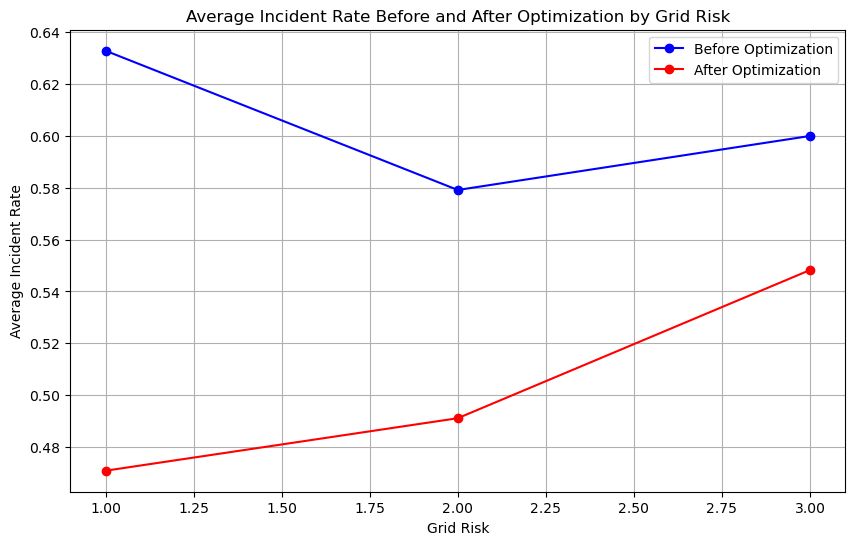

In [76]:
import matplotlib.pyplot as plt

# Prvo ćemo prikazati rezultate u formi grafa
data = {
    "grid_risk": [1, 2, 3],
    "driver_skill": [1, 2, 3],
    "avg_incident_rate_before": [0.632896 , 0.579144, 0.600000],
    "avg_incident_rate_after": [0.470785, 0.491055, 0.548247]
}

df_results = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(df_results['grid_risk'], df_results['avg_incident_rate_before'], label='Before Optimization', marker='o', color='blue')
plt.plot(df_results['grid_risk'], df_results['avg_incident_rate_after'], label='After Optimization', marker='o', color='red')

# Adding labels and title
plt.xlabel('Grid Risk')
plt.ylabel('Average Incident Rate')
plt.title('Average Incident Rate Before and After Optimization by Grid Risk')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()